## XGBOOST with PCA

In [2]:
library(xgboost)
library(readr)
library(stringr)
library(caret)
library(car)

Loading required package: lattice
Loading required package: ggplot2
Warning message:
“package ‘car’ was built under R version 3.4.3”

In [3]:
#### Obtention des données 
data_expressions <- read.csv("data/expressions_train.txt",sep = " ")

X_expressions <- data_expressions[,1:4200]
y_expressions <-data_expressions$y

table(y_expressions)

y_expressions
   anger  disgust     fear      joy  sadness surprise 
      17       15       16       21       23       16 

## Preprocessing 

### Remove 0 columns

In [20]:
X_preprocessed <- X_expressions[, !apply(X_expressions == 0, 2, all)]

### PCA

In [37]:

require(graphics)
prin_comp <- prcomp(X_expressions, center=T )


In [38]:
dim(prin_comp$x)

[1] 108 108

In [39]:
names(prin_comp)

[1] "sdev"     "rotation" "center"   "scale"    "x"

[1] 490358.8 410237.8 287341.8 255097.5 222827.0 195292.4 151713.5 143414.3
 [9] 135954.5 114692.6

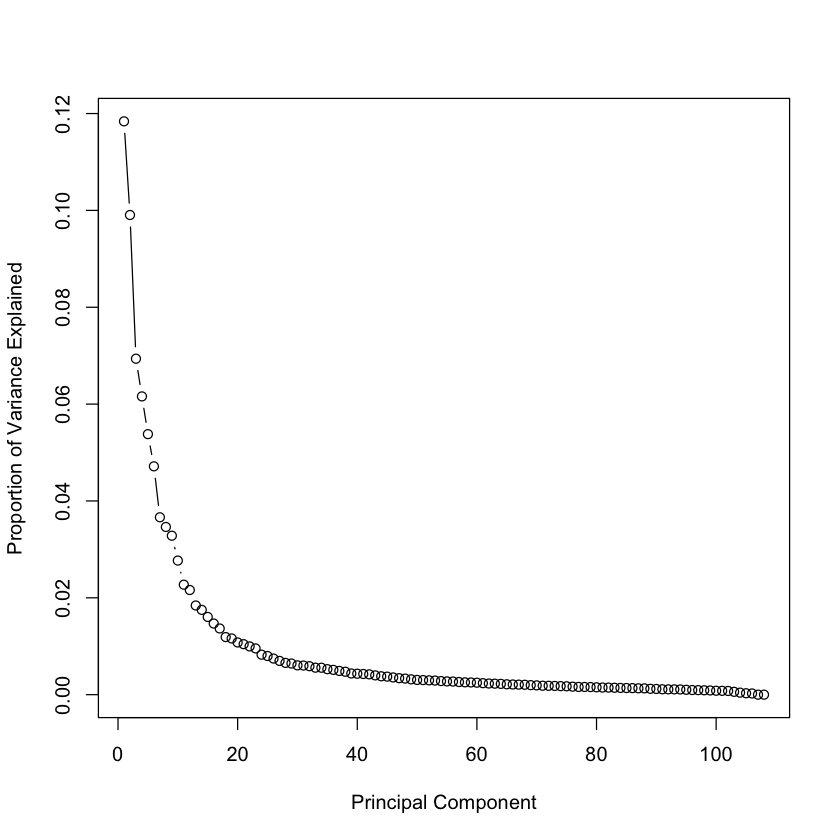

In [40]:
std_dev <- prin_comp$sdev
pr_var <- std_dev^2
pr_var[1:10]
prop_varex <- pr_var/sum(pr_var)
plot(prop_varex, xlab = "Principal Component",
             ylab = "Proportion of Variance Explained",
             type = "b")

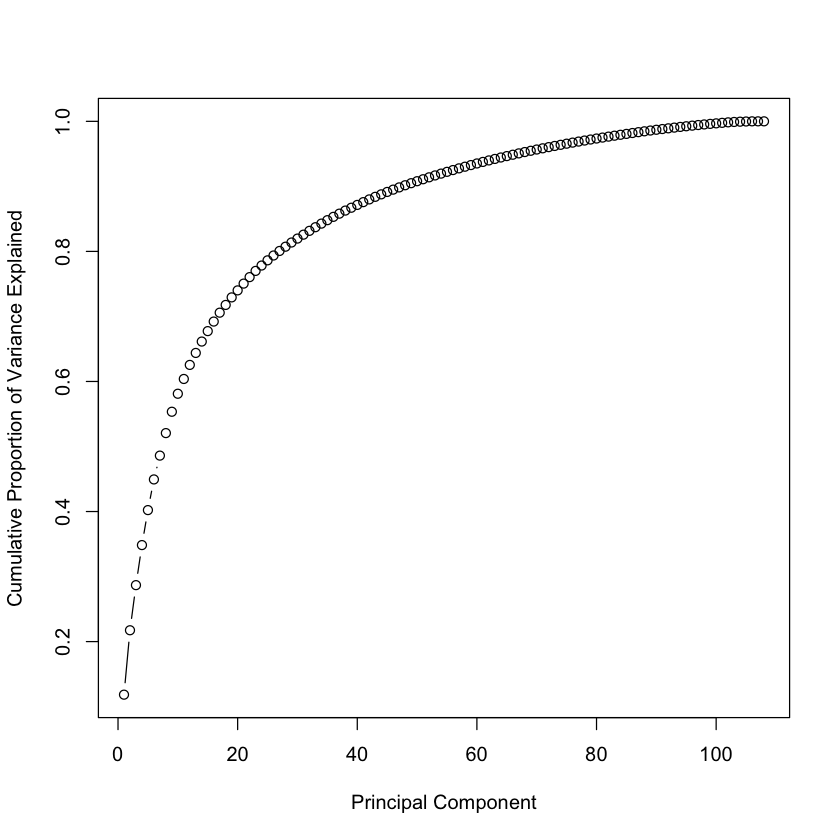

In [41]:
plot(cumsum(prop_varex), xlab = "Principal Component",
              ylab = "Cumulative Proportion of Variance Explained",
              type = "b")

In [42]:
library("caret")

In [43]:
new_data <-  data.frame( prin_comp$x[,1:25],y=y_expressions)

### Training normal model with PCA

In [53]:
n=nrow(data_expressions)
n_folds <- 10
folds_i <- sample(rep(1:n_folds, length.out = n)) # !!! le ntrain doit correspondre à la taille du dataset que l'on utilisera dans la boucle de cross validation 
table(folds_i) # Pas le même nombre d'éléments 
CV<-rep(0,10)
for (k in 1:n_folds) {# we loop on the number of folds, to build k models
  data_to_use <- data_selproc
  ncol <- ncol(data_to_use)
  test_i <- which(folds_i == k)
  train_xy <- data_to_use[-test_i, ]
  test_xy <- data_to_use[test_i, ]
  print(k)
  model_svmLinear <- caret::train(train_xy[,1:ncol-1],train_xy$y,method='rf',trControl=trainControl(
    method = "cv",
    number =10,
    verboseIter = TRUE))
  predictions_svmLinear<-predict.train(object=model_svmLinear,test_xy[,1:ncol-1])
  cf_svmLinear<-caret::confusionMatrix(data= predictions_svmLinear,reference=test_xy$y) 
  CV[k]<- cf_svmLinear$overall["Accuracy"]
}

folds_i
 1  2  3  4  5  6  7  8  9 10 
11 11 11 11 11 11 11 11 10 10 

[1] 1
+ Fold01: mtry=   2 
- Fold01: mtry=   2 
+ Fold01: mtry=  54 
- Fold01: mtry=  54 
+ Fold01: mtry=1480 
- Fold01: mtry=1480 
+ Fold02: mtry=   2 
- Fold02: mtry=   2 
+ Fold02: mtry=  54 
- Fold02: mtry=  54 
+ Fold02: mtry=1480 
- Fold02: mtry=1480 
+ Fold03: mtry=   2 
- Fold03: mtry=   2 
+ Fold03: mtry=  54 
- Fold03: mtry=  54 
+ Fold03: mtry=1480 
- Fold03: mtry=1480 
+ Fold04: mtry=   2 
- Fold04: mtry=   2 
+ Fold04: mtry=  54 
- Fold04: mtry=  54 
+ Fold04: mtry=1480 
- Fold04: mtry=1480 
+ Fold05: mtry=   2 
- Fold05: mtry=   2 
+ Fold05: mtry=  54 
- Fold05: mtry=  54 
+ Fold05: mtry=1480 
- Fold05: mtry=1480 
+ Fold06: mtry=   2 
- Fold06: mtry=   2 
+ Fold06: mtry=  54 
- Fold06: mtry=  54 
+ Fold06: mtry=1480 
- Fold06: mtry=1480 
+ Fold07: mtry=   2 
- Fold07: mtry=   2 
+ Fold07: mtry=  54 
- Fold07: mtry=  54 
+ Fold07: mtry=1480 
- Fold07: mtry=1480 
+ Fold08: mtry=   2 
- Fold08: mtry=   2 
+ Fold08: mtry=  54 
- Fold08: mtry=  54 
+ Fold08: mtry=1480 
- Fold0

In [52]:
CVerror= sum(CV)/length(CV)
CV
CVerror # 0.74
predictions_svmLinear
test_xy$y

[1] 0.7272727 0.5454545 0.6363636 0.7272727 0.9090909 0.5454545 0.8181818
 [8] 0.5454545 0.7000000 0.6000000

[1] 0.6754545

[1] anger    fear     joy      joy      disgust  joy      surprise sadness 
 [9] joy      surprise
Levels: anger disgust fear joy sadness surprise

[1] disgust  joy      joy      joy      surprise joy      surprise anger   
 [9] joy      surprise
Levels: anger disgust fear joy sadness surprise

### Pixels selection 

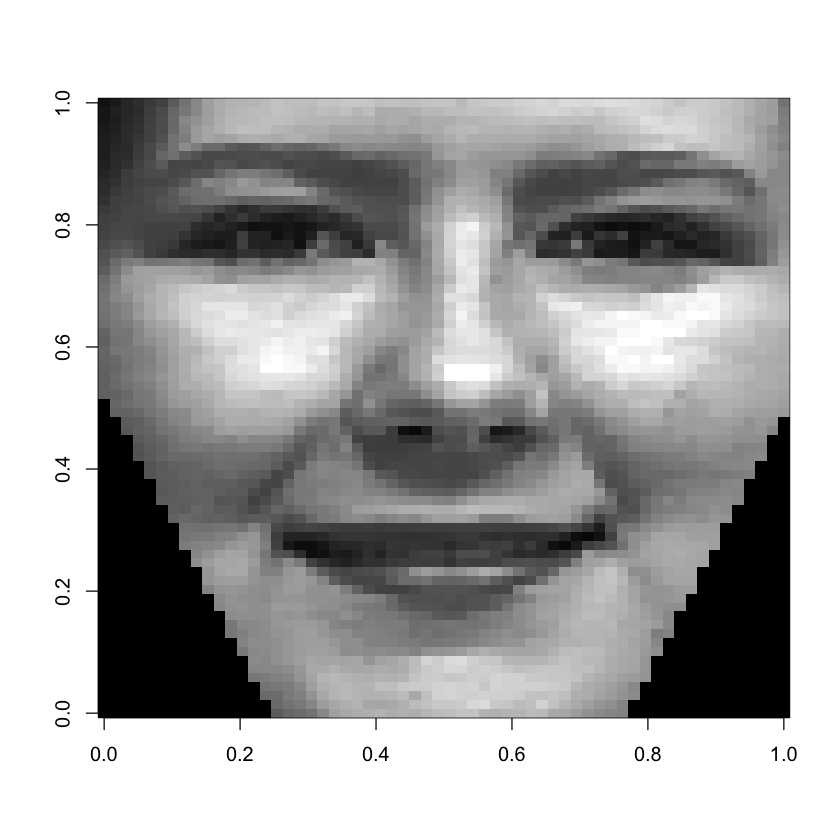

In [9]:
I<-matrix(as.matrix(X_expressions[14,]),60,70)
I1 <- apply(I, 1, rev)
image(t(I1),col=gray(0:255 / 255))

In [10]:
face14 <- X_expressions[14,]

In [11]:
I14<-matrix(as.matrix(X_expressions[14,]),60,70)

In [12]:
dim(face14)
dim(I14)

[1]    1 4200

[1] 60 70

In [13]:
I14_eyes<-matrix(as.matrix(I14[301:1260]),nrow = 60,ncol = 16)
I1 <- apply(I14_eyes, 1, rev)
#image(t(I1),col=gray(0:255 / 255))

In [14]:
I14_mouth<-matrix(as.matrix(I14[301:1260]),nrow = 60,ncol = 16)
I1 <- apply(I14_eyes, 1, rev)
#image(t(I1),col=gray(0:255 / 255))

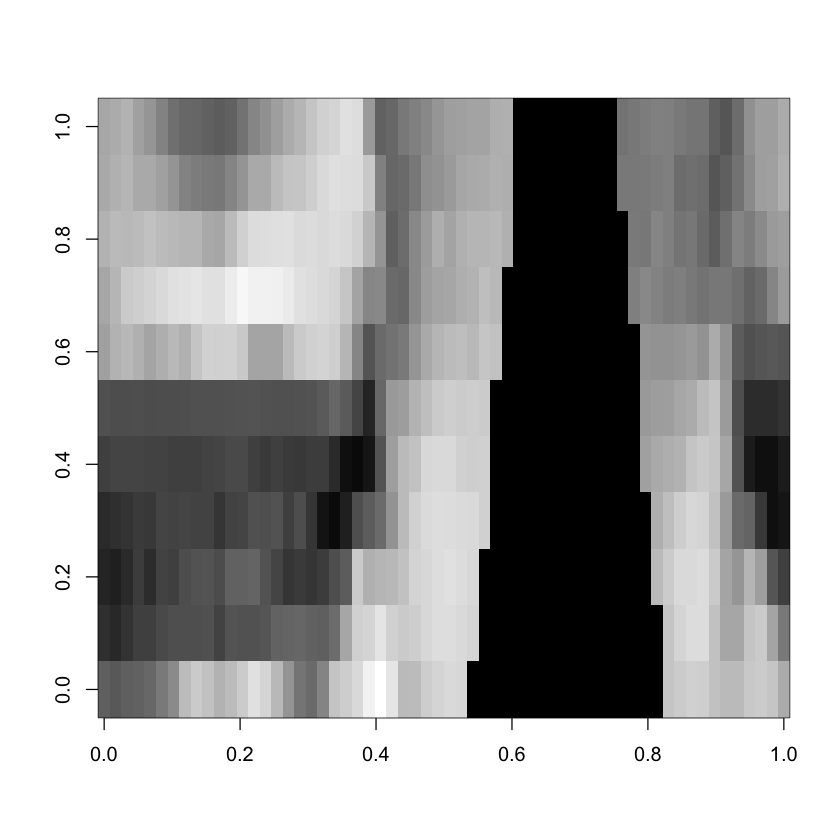

In [15]:
# Selection zone bouche 
I14<-matrix(as.matrix(X_expressions[14,]),60,70)
I14_mouth<-matrix(as.matrix(I14[2601:3260]),nrow = 60,ncol = 11)
Imouth <- apply(I14_mouth, 1, rev)
image(t(Imouth),col=gray(0:255 / 255))

In [16]:
Xselected <- cbind(X_expressions[301:1260],X_expressions[2601:3260])

In [17]:
dim(Xselected)

[1]  108 1620

In [18]:
X_selproc<- Xselected[, !apply(Xselected == 0, 2, all)]
dim(X_selproc)

[1]  108 1481

In [19]:
data_selproc=data.frame(X_selproc,y=y_expressions)

## XGBOOST

In [3]:
I<-matrix(as.matrix(X_expressions[14,]),60,70)
I1 <- apply(I, 1, rev)
## Uncomment to plot image 
#image(t(I1),col=gray(0:255 / 255))
#image(matrix(unlist(I1),ncol=70, byrow =TRUE ),col=gray(0:255 / 255))

In [4]:
dim(X_expressions)
dim(X_expressions[complete.cases(X_expressions), ])
dim(na.omit(X_expressions))
tst <-na.omit(unname(X_expressions))

[1]  108 4200

[1]  108 4200

[1]  108 4200

In [5]:
#### Separation train-test

n=nrow(data_expressions)
ntrain=ceiling(n*2/3)
ntst=n-ntrain
train<-sample(1:n,ntrain)

data_expressions.test<-data_expressions[-train,]
data_expressions.train<-data_expressions[train,]

In [6]:
# Except the y vector, all the feature are numerical so we do not need any transformation there
#sparse_matrix <- sparse.model.matrix(response ~ .-1, data = campaign)
df_X<- X_expressions
sparse_matrix <- sparse.model.matrix(response ~ .-1, data = campaign)
output_vector = df[,response] == "Responder"

ERROR: Error in sparse.model.matrix(response ~ . - 1, data = campaign): could not find function "sparse.model.matrix"
